In [2]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy
from IPython.display import display
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult
from sklearn.linear_model import LogisticRegression


# Ensure reproducibility
np.random.seed(1)

# Append a path if needed
sys.path.append("../")


In [3]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]
preprocessed_dataset = load_preproc_data_adult(['race'])
train, val_test = preprocessed_dataset.split([0.7], shuffle=True)
val, test = val_test.split([0.5], shuffle=True)

In [4]:
# Evaluate fairness metrics before applying bias mitigation
metric_train = BinaryLabelDatasetMetric(train, unprivileged_groups, privileged_groups)
print("Train Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_train.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train.disparate_impact():.4f}")

metric_test = BinaryLabelDatasetMetric(test, unprivileged_groups, privileged_groups)
print("\nTest Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_test.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test.disparate_impact():.4f}")

Train Dataset (Before Transformation):
  Statistical Parity Difference: -0.0970
  Disparate Impact: 0.6151

Test Dataset (Before Transformation):
  Statistical Parity Difference: -0.1066
  Disparate Impact: 0.5863


In [18]:
# Apply Learning Fair Representations (LFR)
lfr = LFR(unprivileged_groups=unprivileged_groups,
          privileged_groups=privileged_groups,
          k=10, Ax=0.1, Ay=1.0, Az=1.5,
           verbose=1)
train_transf = lfr.fit_transform(train)
val_transf = lfr.transform(val)
test_transf = lfr.transform(test)

step: 0, loss: 0.9429282444240035, L_x: 2.6886017876231336,  L_y: 0.6494220610531068,  L_z: 0.016430669739055458
step: 250, loss: 0.8833767561223519, L_x: 2.6861796809593352,  L_y: 0.5906265041234715,  L_z: 0.016088189268631217
step: 500, loss: 0.8315830356570256, L_x: 2.6746701050117467,  L_y: 0.5421958560398844,  L_z: 0.014613446077311054
step: 750, loss: 0.8274702351213499, L_x: 2.667561494261763,  L_y: 0.5397622930809961,  L_z: 0.013967861742784988
step: 1000, loss: 0.748708261397478, L_x: 2.2389918509176074,  L_y: 0.4811630042796582,  L_z: 0.029097381350706053
step: 1250, loss: 0.7348009478215549, L_x: 2.2341693787501145,  L_y: 0.4728664356292679,  L_z: 0.025678382878183727
step: 1500, loss: 0.7121227188470148, L_x: 2.2051364397035713,  L_y: 0.46488130992087,  L_z: 0.017818509970525115
step: 1750, loss: 0.7323326438873091, L_x: 1.85102108388765,  L_y: 0.5012024060677446,  L_z: 0.03068541962053297
step: 2000, loss: 0.6775410931547359, L_x: 1.9705180204726955,  L_y: 0.44792588756944

In [19]:
# Evaluate fairness metrics after applying LFR
metric_train_after = BinaryLabelDatasetMetric(train_transf, unprivileged_groups, privileged_groups)
print("\nTrain Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_train_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train_after.disparate_impact():.4f}")

metric_test_after = BinaryLabelDatasetMetric(test_transf, unprivileged_groups, privileged_groups)
print("\nTest Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_test_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test_after.disparate_impact():.4f}")



Train Dataset (After Transformation):
  Statistical Parity Difference: -0.0399
  Disparate Impact: 0.7105

Test Dataset (After Transformation):
  Statistical Parity Difference: -0.0398
  Disparate Impact: 0.7115


In [20]:
# Standardize the features
scaler = StandardScaler()
train.features = scaler.fit_transform(train.features)
val.features = scaler.transform(val.features)
test.features = scaler.transform(test.features)


In [21]:
classifier = LogisticRegression(random_state=1)


In [22]:
# Train a classifier on original training data
classifier.fit(train.features, train.labels.ravel())

# Predict on validation set
val_scores = classifier.predict_proba(val.features)[:, 1] #only for the favorable class?

# Select best threshold for validation set
thresholds = np.arange(0.01, 1, 0.01)
val_balanced_accs = []

for threshold in thresholds:
    val_LR_predictions = (val_scores >= threshold).astype(int)

    val_with_LR_scores = copy.deepcopy(val)
    val_with_LR_scores.labels = val_LR_predictions.reshape(-1, 1)  # Update labels with predictions

    val_metric = ClassificationMetric(val, val_with_LR_scores,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
    balanced_acc = (val_metric.true_positive_rate() + val_metric.true_negative_rate()) / 2
    val_balanced_accs.append(balanced_acc)

best_index = np.argmax(val_balanced_accs)
best_threshold = thresholds[best_index]
best_balanced_acc = val_balanced_accs[best_index]

print(f"Best Threshold (validation): {best_threshold}")
print(f"Best Balanced Accuracy (validation): {best_balanced_acc}")

Best Threshold (validation): 0.29000000000000004
Best Balanced Accuracy (validation): 0.746316300422052


In [23]:
# Apply the best threshold to the test set
test_scores = classifier.predict_proba(test.features)[:, 1]
test_LR_predictions= (test_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_with_LR_scores = copy.deepcopy(test)
test_with_LR_scores.labels = test_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_metric = ClassificationMetric(test, test_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_metric.true_positive_rate()
true_negative_rate = test_metric.true_negative_rate()
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy}")

# Statistical Parity Difference
statistical_parity_difference = test_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference}")

# Disparate Impact
disparate_impact = test_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact}")

# Average Odds Difference
average_odds_difference = test_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference}")

# Equal Opportunity Difference
equal_opportunity_difference = test_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference}")

# Theil Index
theil_index = test_metric.theil_index()
print(f"Theil Index (test): {theil_index}")

Balanced Accuracy (test): 0.7437474047111203
Statistical Parity Difference (test): -0.2434802481451035
Disparate Impact (test): 0.41221836766195447
Average Odds Difference (test): -0.19657761474195767
Equal Opportunity Difference (test): -0.20197760419162636
Theil Index (test): 0.1129175713864926


In [24]:
# Plot Test Metrics Over Thresholds
test_balanced_accs = []
test_disp_impacts = []
test_avg_odds_diffs = []

for threshold in thresholds:
    test_predictions = (test_scores >= threshold).astype(int)
    test_with_scores = copy.deepcopy(test)
    test_with_scores.labels = test_predictions.reshape(-1, 1)

    test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
    test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
    test_disp_impacts.append(test_metric.disparate_impact())
    test_avg_odds_diffs.append(test_metric.average_odds_difference())

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


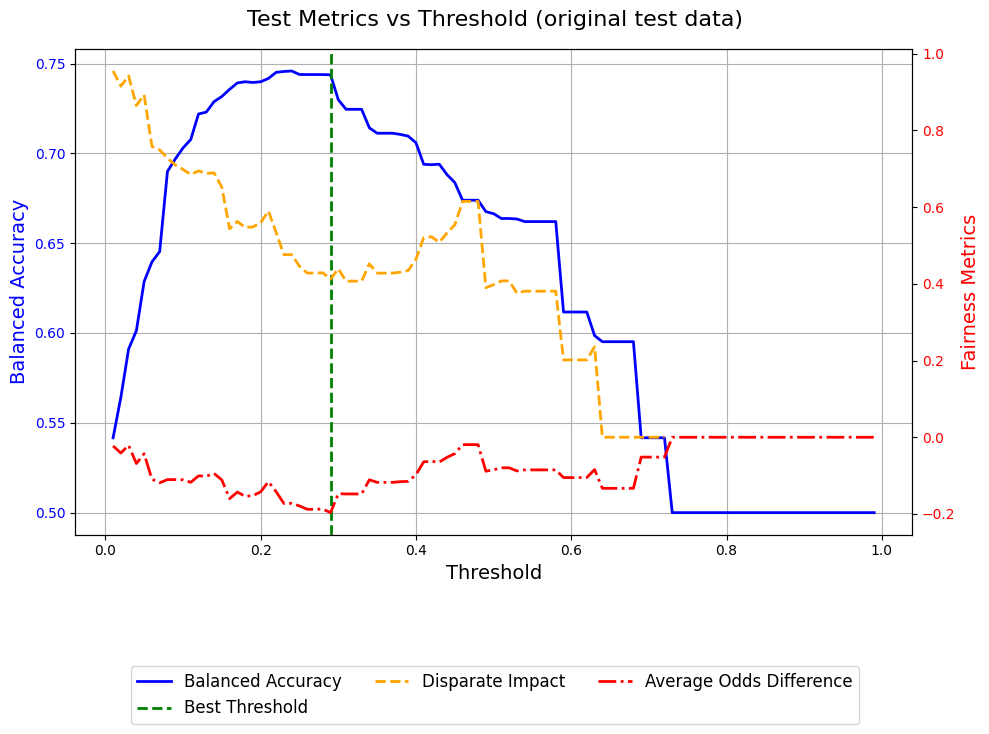

In [25]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (original test data)", fontsize=16)
fig.tight_layout()
plt.show()

TRANSFORMED DATASET

Unlike reweighing, where a classifier must be trained to evaluate predictions after adjusting instance weights, LFR generates its own scores as part of its optimization process. These scores are computed to balance reconstruction accuracy, prediction accuracy, and fairness. Since LFR directly provides these fairness-aware scores, there is no need to train a separate classifier on the transformed dataset.

In [26]:
# Apply the best threshold to the transf test set
test_transf_scores = test_transf.scores.ravel()
test_transf_LR_predictions= (test_transf_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_transf_with_LR_scores = copy.deepcopy(test)
test_transf_with_LR_scores.labels = test_transf_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_transf_metric = ClassificationMetric(test, test_transf_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_transf_metric.true_positive_rate()
true_negative_rate = test_transf_metric.true_negative_rate()
balanced_accuracy_transf = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy_transf}")

# Statistical Parity Difference
statistical_parity_difference_transf = test_transf_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference_transf}")

# Disparate Impact
disparate_impact_transf = test_transf_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact_transf}")

# Average Odds Difference
average_odds_difference_transf = test_transf_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference_transf}")

# Equal Opportunity Difference
equal_opportunity_difference_transf = test_transf_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference_transf}")

# Theil Index
theil_index_transf = test_transf_metric.theil_index()
print(f"Theil Index (test): {theil_index_transf}")

Balanced Accuracy (test): 0.7237090906512884
Statistical Parity Difference (test): -0.03860947638495721
Disparate Impact (test): 0.8707279315093895
Average Odds Difference (test): 0.047559249777146984
Equal Opportunity Difference (test): 0.10427149726042717
Theil Index (test): 0.13532040878255666


In [27]:
# Plot Test Metrics Over Thresholds
test_transf_balanced_accs = []
test_transf_disp_impacts = []
test_transf_avg_odds_diffs = []

for threshold in thresholds:
    test_transf_predictions = (test_transf_scores >= threshold).astype(int)
    test_transf_with_scores = copy.deepcopy(test)
    test_transf_with_scores.labels = test_transf_predictions.reshape(-1, 1)

    test_transf_metric = ClassificationMetric(test, test_transf_with_scores, unprivileged_groups, privileged_groups)
    test_transf_balanced_accs.append((test_transf_metric.true_positive_rate() + test_transf_metric.true_negative_rate()) / 2)
    test_transf_disp_impacts.append(test_transf_metric.disparate_impact())
    test_transf_avg_odds_diffs.append(test_transf_metric.average_odds_difference())

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


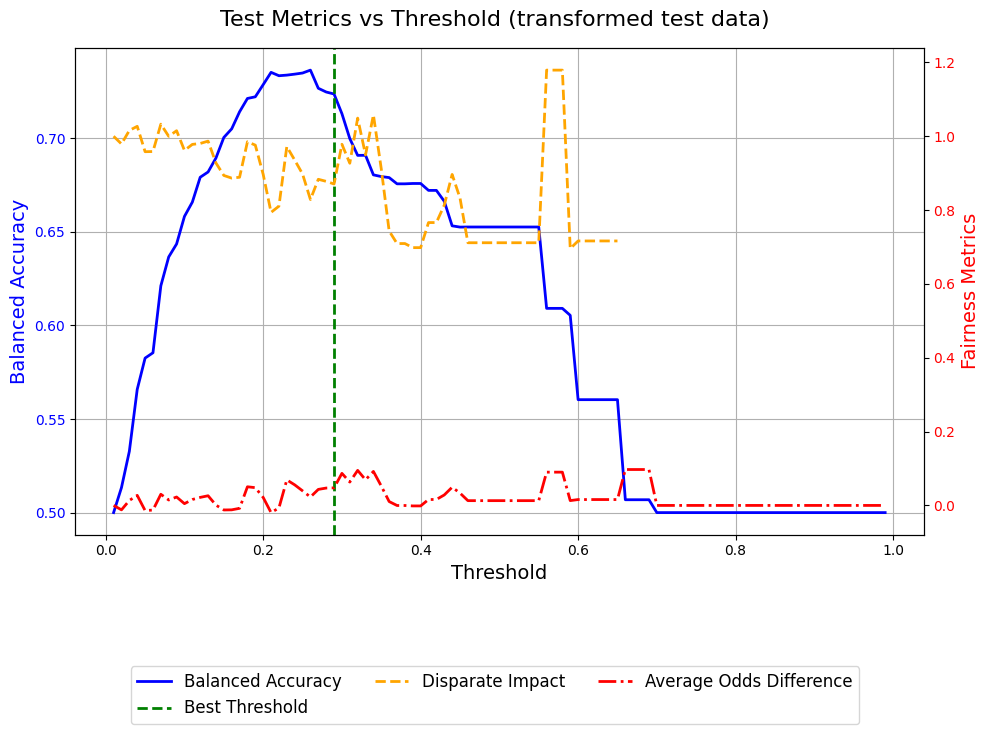

In [28]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_transf_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_transf_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_transf_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

#ax2.set_ylim(-0.05, 0.07)  # I could do this in order to see the average odds better but then i dont see disparate impact, therefore its maybe better to either make abs 1-disparate OR plot two different plots 
ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (transformed test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [29]:
# Organizing the metrics with actual calculated values
results_data = {
    "Dataset": [
        "Train", "Train", "Test", "Test", 
        "Train", "Train", "Test", "Test", 
        "Validation", "Validation", 
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)"
    ],
    "Stage": [
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Best Threshold (Validation)", "Best Threshold (Validation)",
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold"
    ],
    "Metric": [
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Disparate Impact", "Disparate Impact",
        "Disparate Impact", "Disparate Impact",
        "Threshold", "Balanced Accuracy",
        "Balanced Accuracy", "Balanced Accuracy", 
        "Statistical Parity Difference", "Statistical Parity Difference", 
        "Disparate Impact", "Disparate Impact",
        "Average Odds Difference", "Average Odds Difference",
        "Equal Opportunity Difference", "Equal Opportunity Difference", 
        "Theil Index", "Theil Index"
    ],
    "Value": [
        metric_train.mean_difference(),
        metric_train_after.mean_difference(),
        metric_test.mean_difference(),
        metric_test_after.mean_difference(),
        metric_train.disparate_impact(),
        metric_train_after.disparate_impact(),
        metric_test.disparate_impact(),
        metric_test_after.disparate_impact(),
        best_threshold,
        best_balanced_acc,
        balanced_accuracy, balanced_accuracy_transf,
        statistical_parity_difference, statistical_parity_difference_transf,
        disparate_impact, disparate_impact_transf,
        average_odds_difference, average_odds_difference_transf,
        equal_opportunity_difference, equal_opportunity_difference_transf,
        theil_index, theil_index_transf
    ]
}

# Create the DataFrame
results_table = pd.DataFrame(results_data)

# Display the table
#display(results_table)


**Fairness Metrics Before and After Transformation**
- This table represents the fairness metrics (Statistical Parity Difference and Disparate Impact) for both the train and test datasets, before and after applying the transformation.

**Validation Metrics for Threshold Selection**
- This table contains metrics related to the validation phase, including the best threshold and corresponding balanced accuracy.

**Test Metrics After Applying Threshold**
- This table summarizes fairness and performance metrics calculated on the test set of the original and transformed dataset after applying the selected threshold.


In [30]:
# Separate the data into three groups
fairness_metrics = results_table.iloc[0:8].reset_index(drop=True)
validation_metrics = results_table.iloc[8:10].reset_index(drop=True)
test_metrics = results_table.iloc[10:22].reset_index(drop=True)

# Name the tables
fairness_metrics.name = "Fairness Metrics Before and After Transformation"
validation_metrics.name = "Validation Metrics for Threshold Selection"
test_metrics.name = "Test Metrics After Applying Threshold On Original and Transformed"

# Display the tables with their names
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)


'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.097036
1,Train,After Transformation,Statistical Parity Difference,-0.039875
2,Test,Before Transformation,Statistical Parity Difference,-0.106639
3,Test,After Transformation,Statistical Parity Difference,-0.039785
4,Train,Before Transformation,Disparate Impact,0.615086
5,Train,After Transformation,Disparate Impact,0.710453
6,Test,Before Transformation,Disparate Impact,0.586297
7,Test,After Transformation,Disparate Impact,0.711538


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.290000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.746316


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.743747
1,Test (Transformed),After Threshold,Balanced Accuracy,0.723709
2,Test (Original),After Threshold,Statistical Parity Difference,-0.243480
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.038609
4,Test (Original),After Threshold,Disparate Impact,0.412218
5,Test (Transformed),After Threshold,Disparate Impact,0.870728
6,Test (Original),After Threshold,Average Odds Difference,-0.196578
7,Test (Transformed),After Threshold,Average Odds Difference,0.047559
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.201978
9,Test (Transformed),After Threshold,Equal Opportunity Difference,0.104271
